## Calibrate the camera and undistort the image

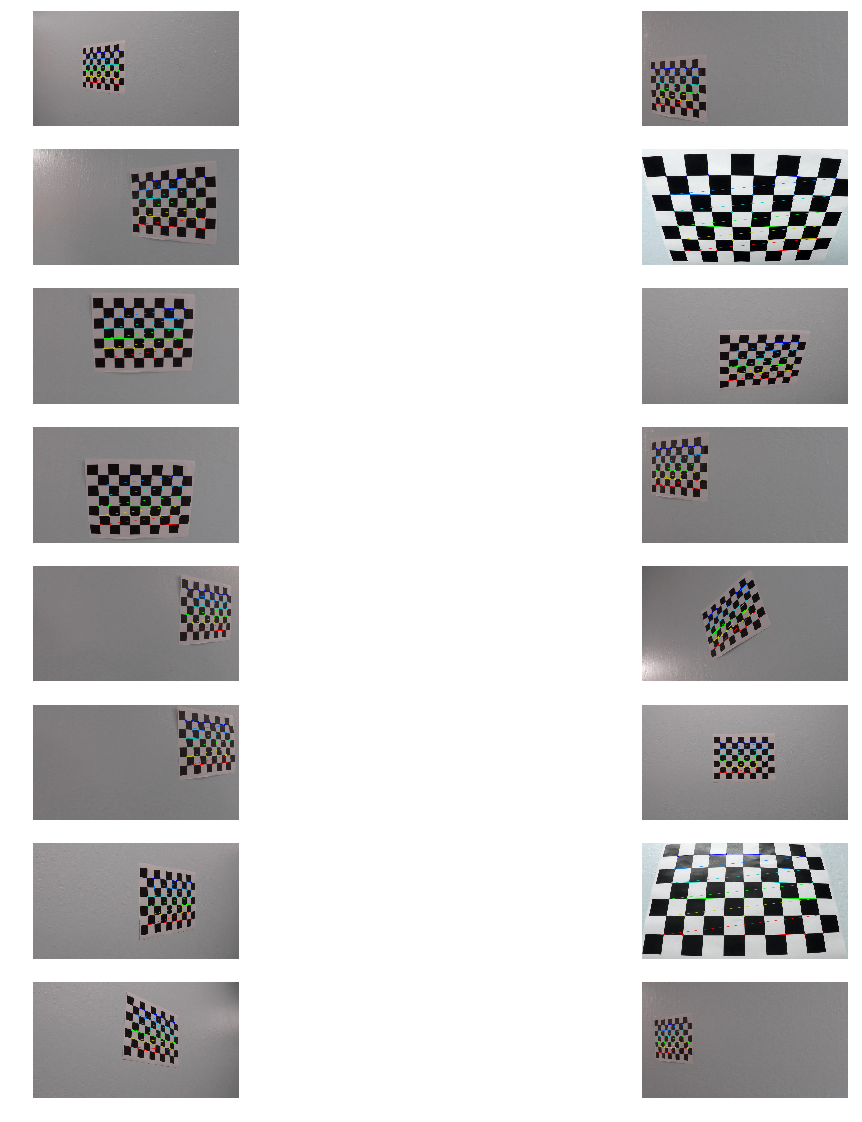

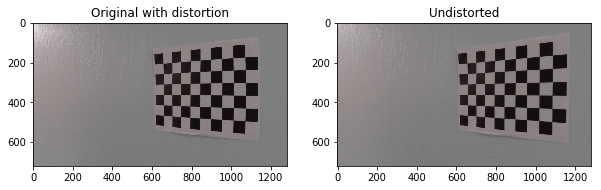

In [36]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
f, ax = plt.subplots(8,2, figsize=(20,20))
ax = ax.ravel()

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        #improves the accuracy 
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        ax[idx].axis('off')
        ax[idx].imshow(img)
        
        
#Read an image to test if it cant undistortion
img = cv2.imread('./camera_cal/calibration12.jpg')
#Calibrate your camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#undistort the image
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.set_title('Original with distortion')
ax1.imshow(img)
ax2.set_title('Undistorted')
ax2.imshow(dst)


### Undistort test image


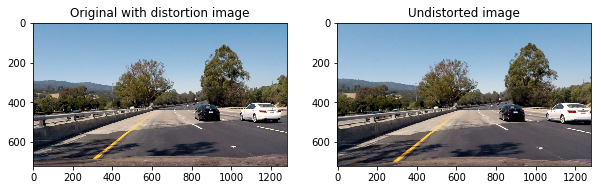

In [31]:
#Read an image to test if it cant undistortion
img = cv2.imread('./test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#undistort the image
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.set_title('Original with distortion image')
ax1.imshow(img)
ax2.set_title('Undistorted image')
ax2.imshow(dst)

### Function to undistorted image and draw lines

In [37]:
### Function to undistorted image and draw lines

def dist2undist(img):
    #undistort the image
    return cv2.undistort(img, mtx, dist, None, mtx)

def drawBoundaries(img):
    x = img.shape[1]
    y = img.shape[0]
#    print(x,y)
    x1, y1, x2, y2, x3, y3, x4, y4 = (0.15*x),(0.9*y),(0.40*x),(0.65*y),(0.60*x),(0.65*y),(0.9*x),(0.9*y)
#     pts = np.array([[200,650],[550,450],[750,450],[1100,650]], np.int32)
    pts = np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]], np.int32)
    pts = pts.reshape((-1,1,2))
    return cv2.polylines(img,[pts],True,(0,255,255),3)
    

### Undistort and image and the draw boundary

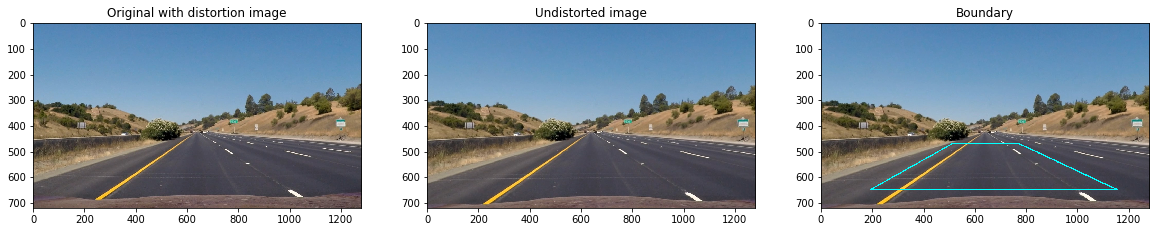

In [38]:
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# print(img.shape)

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,20))
ax1.set_title('Original with distortion image')
ax1.imshow(img)

#undistort the image
dst = dist2undist(img)
ax2.set_title('Undistorted image')
ax2.imshow(dst)

#draw boundaries to the image
boundary = drawBoundaries(dst)
ax3.set_title('Boundary')
ax3.imshow(boundary)

### Warp the images 

In [39]:
def warp(img):
    x, y = img.shape[1], img.shape[0]
    
    x1, y1, x2, y2, x3, y3, x4, y4 = (0.15*x),(0.9*y),(0.40*x),(0.65*y),(0.60*x),(0.65*y),(0.9*x),(0.9*y)
#     x1, y1, x2, y2, x3, y3, x4, y4 = (0.15*x),(y),(0.40*x),(0.65*y),(0.60*x),(0.65*y),(0.9*x),(y)
    
    src=np.float32(
        [[x1,y1],
         [x2,y2],
         [x3,y3],
         [x4,y4]])
    
    dst=np.float32(
        [[0.15*x,0.9*y],
         [0.05*x,0.15*y],
         [0.95*x,0.15*y],
         [0.9*x,0.9*y]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, (x,y), flags=cv2.INTER_LINEAR)
    
    return warped, Minv

### Perspective transformation of the image

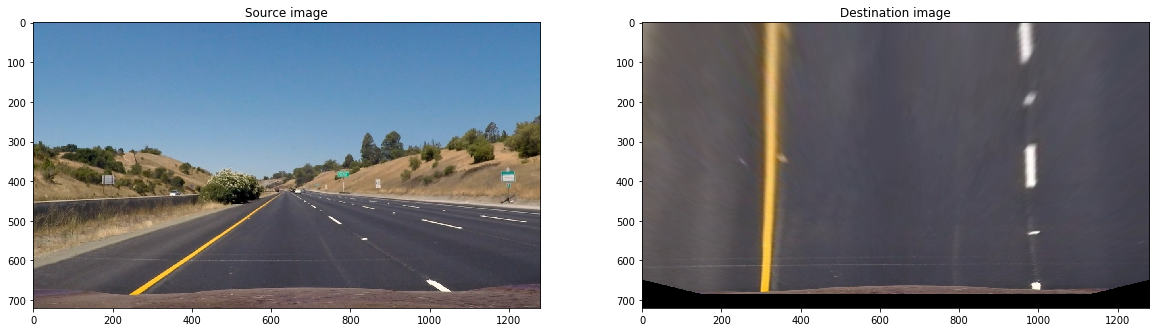

In [40]:
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = dist2undist(img)
warped_img, Minv = warp(dst)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))
ax1.set_title('Source image')
ax1.imshow(img)
ax2.set_title('Destination image')
ax2.imshow(warped_img)

### Threshold function to identify the lanes in the images

In [41]:
def colorThreshold(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=9)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    scaled_mag = np.uint8(255*magnitude/np.max(magnitude))
    sob_mag = np.zeros_like(scaled_mag)
    sob_mag[(scaled_mag >= 50) & (scaled_mag <= 255)] = 1
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=15)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=15)
    absolute = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    absbinary = np.zeros_like(absolute)
    absbinary[(absbinary >= 0.7) & (absbinary <= 1.3)] = 1
    
    sobel_binary = np.zeros_like(img[:,:,0])
    sobel_binary[((sob_mag == 1) & (absbinary == 1))] = 1

    r_ch = img[:,:,2]
    r_bin = np.zeros_like(img[:,:,0])
    r_bin[(r_ch > 220) & (r_ch <= 255)] = 1

    hlsImg = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_ch = hlsImg[:,:,2]
    s_bin = np.zeros_like(s_ch)
    s_bin[(s_ch > 150) & (s_ch <= 255)] = 1

    # Combine two color channels
    color_binary = np.zeros_like(img[:,:,0])
    color_binary[(s_bin == 1) | (r_bin == 1)] = 1
    
    all_binary = np.zeros_like(img[:,:,0])
    all_binary[(sobel_binary == 1) | (color_binary == 1)] = 255
   
    # Return binary output image
    return all_binary

### Visualize the lanes after thresholding

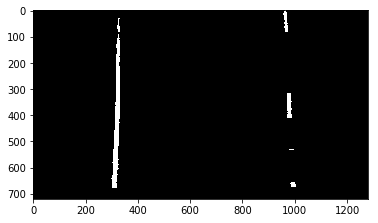

In [42]:
combined = colorThreshold(warped_img)
plt.imshow(combined,cmap='gray')

### Visualize all the different stages of the image.

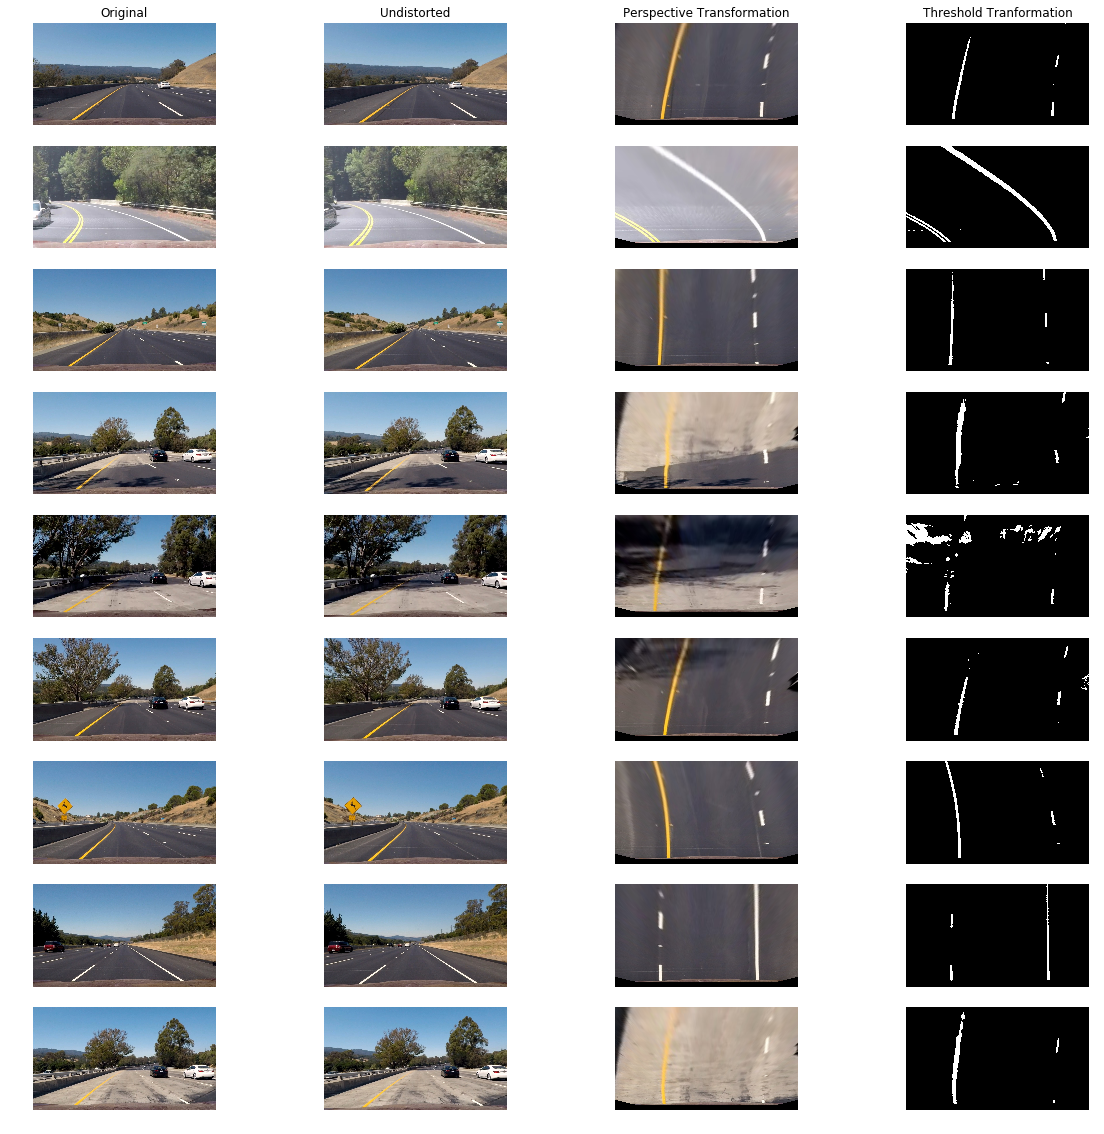

In [48]:
images = glob.glob('./test_images/*.jpg')
f, ax = plt.subplots(9,4, figsize=(20,20))
ax = ax.ravel()
idx = 0
for fname in images:
    
    img = cv2.imread(fname)
    original_img = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = dist2undist(img)
    warped_img,Minv = warp(dst)
    binary_warped = colorThreshold(warped_img)
    
    ax[idx].imshow(img)
    ax[idx].axis('off')

    ax[idx+1].imshow(dst)
    ax[idx+1].axis('off')
    
    ax[idx+2].imshow(warped_img)
    ax[idx+2].axis('off')
    
    ax[idx+3].imshow(binary_warped,cmap='gray')
    ax[idx+3].axis('off')
    idx+=4

ax[0].set_title('Original')
ax[1].set_title('Undistorted')
ax[2].set_title('Perspective Transformation')
ax[3].set_title('Threshold Tranformation')

### Create a sample pipeline for images

In [49]:
img = cv2.imread('./test_images/test3.jpg')
original_img = img
dst = dist2undist(img)
warped_img,Minv = warp(dst)
binary_warped = colorThreshold(warped_img)

### Sliding window function

In [50]:
def sliding_window(binary_warped):

    #Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(leftx)!=0:
        left_fit = np.polyfit(lefty, leftx, 2)
        print
    if len(rightx)!=0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return left_fit, right_fit, histogram

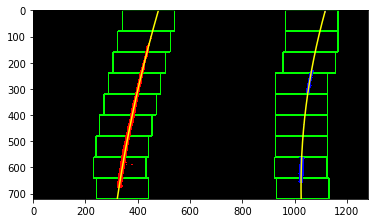

In [51]:
left_fit, right_fit,hist = sliding_window(binary_warped)

### Histogram to identify lanes

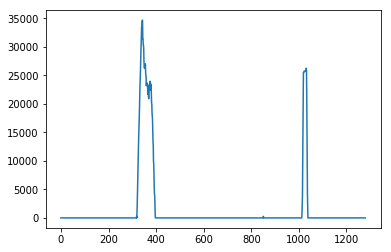

In [52]:
plt.plot(hist)

In [53]:
def polyfit_binary(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx)!=0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx)!=0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
      
    return left_fit, right_fit, left_lane_inds, right_lane_inds

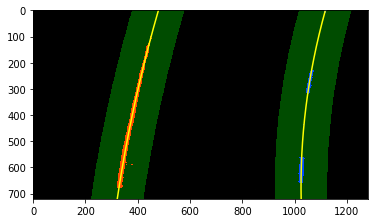

In [54]:
left_fitx, right_fitx ,c, d= polyfit_binary(binary_warped, left_fit, right_fit)

In [55]:
def compute_radius(ploty, left_fit, right_fit):
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_curverad = ((1 + (2*left_fitx[0]*y_eval + left_fitx[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fitx[0]*y_eval + right_fitx[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print('left:',left_curverad, 'right:',right_curverad)

In [56]:
def compute_actual_radius(ploty, leftx, rightx, ym_per_pix, xm_per_pix):
    
    left_fitx = leftx[0]*ploty**2 + leftx[1]*ploty + leftx[2]
    right_fitx = rightx[0]*ploty**2 + rightx[1]*ploty + rightx[2]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad,right_curverad

In [57]:
ploty = np.linspace(0, 719, num=720)
y_eval = np.max(ploty)
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 

compute_radius(ploty, left_fitx, right_fitx)
left_fit_cr, right_fit_cr= compute_actual_radius(ploty, left_fitx, right_fitx, ym_per_pix, xm_per_pix)
print ('left lane:',left_fit_cr,'right lane:',right_fit_cr)

left: 1.67594255271e+21 right: 1.00472276294e+22
left lane: 1681.3489539 right lane: 793.982571572


In [58]:
def draw_lines(binary_warped, original_img, l_fit, r_fit, Minv,ploty):
    if l_fit is None or r_fit is None:
        return original_img

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, 719, num=720)
    y,x = binary_warped.shape

    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (x, y)) 
    # Combine the result with the original image
#     undist = np.copy(original_img)
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    return result

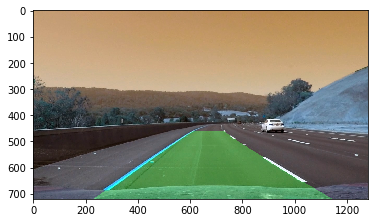

In [59]:
x=draw_lines(binary_warped, original_img, left_fit, right_fit, Minv, ploty)

### Class to capture lane information and functions for updating

In [60]:
class Lane():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #default coefficents
        self.default_coeff = np.array([0.001,1.0,100], dtype='float') 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def update(self,fit):
        if fit != None and self.best_fit!= None:
            self.diffs = abs(fit-self.best_fit)
            if np.any(np.greater(self.diffs,self.default_coeff)):
                self.detected = False
        if fit != None and not np.any(np.greater(self.diffs,self.default_coeff)):
            self.detected = True
            self.fit = fit
            self.best_fit = fit
            self.recent_xfitted.append(self.fit)
            if len(self.recent_xfitted) > 5:
                self.current_fit = self.recent_xfitted[len(self.recent_xfitted)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
            else:    
                self.best_fit= np.average(self.recent_xfitted, axis=0)
        else:
            self.current_fit = self.recent_xfitted[len(self.recent_xfitted)-1:]
            self.best_fit = np.average(self.current_fit, axis=0)
            self.detected = False


        

### Defining support functions sliding window, polyfit, validate lanes and pipeline

In [61]:
def slWinFunction(binary_warped):   
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    left_fit = None
    right_fit = None
    

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(leftx)!=0:
        left_fit = np.polyfit(lefty, leftx, 2)
        print
    if len(rightx)!=0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit
    
def polyfit(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx)!=0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx)!=0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit    

### Identify the intercepts

In [62]:
def validateIntercepts(l_fit, r_fit, img):
    y = img.shape[0]
    lx = l_fit[0]*y**2 + l_fit[1]*y + l_fit[2]
    rx = r_fit[0]*y**2 + r_fit[1]*y + r_fit[2]
    diff = rx-lx
    if diff >800 and diff<400:
        l_fit = None
        r_fit = None
    return l_fit, r_fit

### Pipeline

In [63]:
def pipeline(image):
    original_img = np.copy(image)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dst = dist2undist(image)
    warped_img,Minv = warp(dst)
    binary_warped = colorThreshold(warped_img)

    if left_lane.detected == False or right_lane.detected == False:
        left_fit, right_fit = slWinFunction(binary_warped)
    else:
        left_fit, right_fit = polyfit(binary_warped, left_lane.best_fit, right_lane.best_fit)
    
    if left_fit !=None and right_fit != None:
        left_fit, right_fit = validateIntercepts(left_fit, right_fit, binary_warped)

    left_lane.update(left_fit)
    right_lane.update(right_fit)

    if left_lane.best_fit!=None and right_lane.best_fit !=None:
        ploty = np.linspace(0, 719, num=720)
        y_eval = np.max(ploty)
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 
        
        out = draw_lines(binary_warped, original_img, left_lane.best_fit, right_lane.best_fit, Minv, ploty)
        
        left_r, right_r=compute_actual_radius(ploty, left_lane.best_fit, right_lane.best_fit, ym_per_pix, xm_per_pix)
        actual_center = image.shape[1]/2
        left_lane_pos = left_lane.best_fit[0]*image.shape[0]**2 + left_lane.best_fit[1]*image.shape[0] + left_lane.best_fit[2]
        right_lane_pos = right_lane.best_fit[0]*image.shape[0]**2 + right_lane.best_fit[1]*image.shape[0] + right_lane.best_fit[2]
        lanes_center = (left_lane_pos + right_lane_pos) /2
        dist_from_center = (actual_center - lanes_center) * xm_per_pix
        
        cv2.putText(out, 'Radius of curvature = ' + str(round((left_r+right_r)/2))+' (m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
        cv2.putText(out, 'Car is ' + str(abs(round(dist_from_center, 3)))+' (m) from center',(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    
        return out
    else:
        return original_img
    

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()
left_lane = Lane()
right_lane = Lane()

challenge_output = 'project_video_output.mp4'
clip3 = VideoFileClip('project_video.mp4')
challenge_clip = clip3.fl_image(pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [19:06<00:00,  1.82it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 14min 32s, sys: 27.8 s, total: 15min
Wall time: 19min 13s
